In [23]:
import pandas as pd 
def load_train_data():
    data = pd.read_csv('Acoustic_train.csv')
    return data

def load_test_data():
    data = pd.read_csv('Acoustic_test_no_class.csv')
    return data

train_data = load_train_data()
test_data = load_test_data()

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical


In [25]:

# Load and prepare the data
X_train = train_data.drop(columns=["Index", "Class"])
y_train = train_data["Class"]


In [26]:

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [27]:

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
num_classes = len(np.unique(y_train_encoded))


In [28]:

# Reshape data for RNN input (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)


In [29]:

# Split into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_reshaped, y_train_encoded, test_size=0.2, random_state=42
)


In [30]:

# Convert labels to one-hot encoding
y_train_split_onehot = to_categorical(y_train_split, num_classes=num_classes)
y_val_onehot = to_categorical(y_val, num_classes=num_classes)


In [31]:
from tensorflow.keras.regularizers import l2


# Build RNN model
model = Sequential([
    LSTM(64, input_shape=(X_train_split.shape[1], X_train_split.shape[2]), activation='tanh', return_sequences=False),
    Dropout(0.2),
   Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(num_classes, activation='softmax')
])


C:\Users\souri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [33]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Add to model.fit
history = model.fit(
    X_train_split, y_train_split_onehot,
    validation_data=(X_val, y_val_onehot),
    epochs=100, batch_size=32, verbose=1,
    callbacks=[early_stopping]
)



Epoch 1/100


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.3417 - loss: 1.8124 - val_accuracy: 0.4833 - val_loss: 1.7445
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5219 - loss: 1.7271 - val_accuracy: 0.5500 - val_loss: 1.6779
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6339 - loss: 1.6441 - val_accuracy: 0.6167 - val_loss: 1.6072
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6807 - loss: 1.5717 - val_accuracy: 0.6500 - val_loss: 1.5367
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7279 - loss: 1.5039 - val_accuracy: 0.6833 - val_loss: 1.4671
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7616 - loss: 1.4097 - val_accuracy: 0.6833 - val_loss: 1.3946
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7688 - loss: 1.3126 - val_accuracy: 0.7000 - val_loss: 1.3235
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8157 - loss: 1.2208 - val_accuracy: 0.7000 - val_loss: 1.2546
Epoch 9/100

In [34]:

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val_onehot)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7604 - loss: 0.7155 
Validation Loss: 0.7347713112831116
Validation Accuracy: 0.75


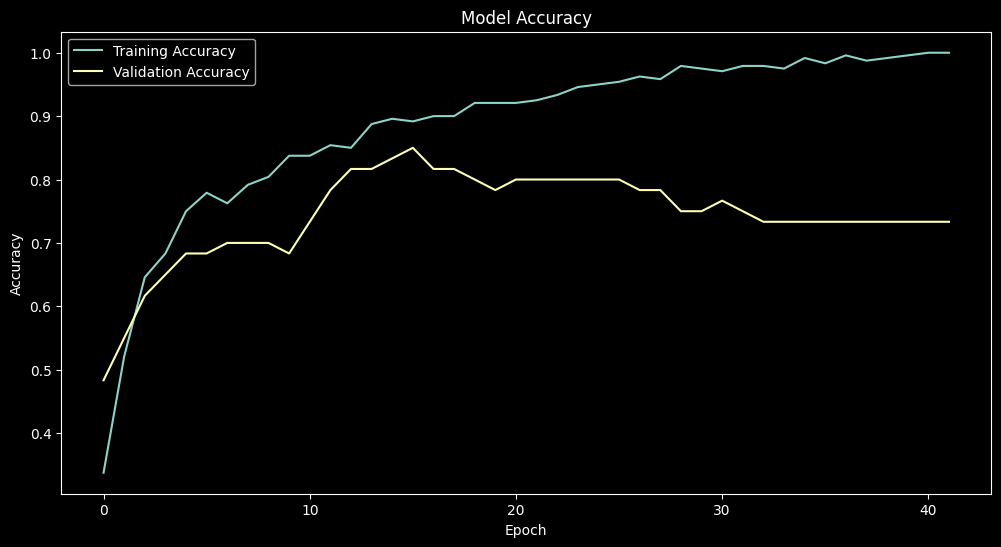

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


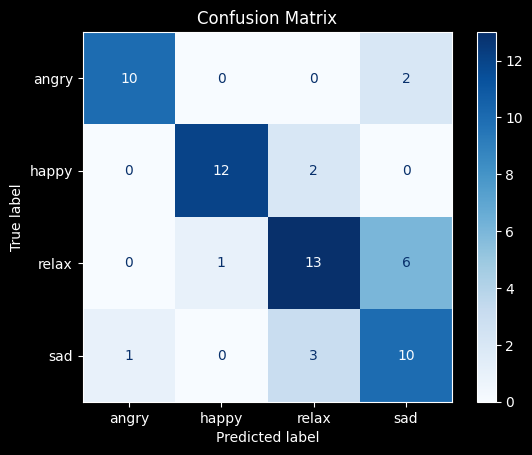

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Plot accuracy change graph
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [36]:
# Preprocess the test data
X_test = test_data.drop(columns=["Index"])
X_test_scaled = scaler.transform(X_test)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)

# Make predictions
y_test_pred = model.predict(X_test_reshaped)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Decode the predicted labels
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred_classes)

# Print the predicted labels
print(y_test_pred_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
['relax' 'sad' 'relax' 'sad' 'relax' 'relax' 'sad' 'sad' 'sad' 'happy'
 'relax' 'happy' 'sad' 'relax' 'happy' 'relax' 'angry' 'angry' 'sad'
 'relax' 'sad' 'angry' 'angry' 'sad' 'sad' 'angry' 'happy' 'sad' 'angry'
 'happy' 'angry' 'happy' 'sad' 'relax' 'sad' 'angry' 'happy' 'angry'
 'happy' 'happy' 'angry' 'relax' 'relax' 'relax' 'relax' 'angry' 'happy'
 'happy' 'relax' 'happy' 'relax' 'angry' 'happy' 'relax' 'angry' 'relax'
 'relax' 'happy' 'relax' 'happy' 'happy' 'sad' 'happy' 'relax' 'happy'
 'relax' 'happy' 'sad' 'happy' 'relax' 'relax' 'happy' 'sad' 'sad' 'angry'
 'sad' 'happy' 'angry' 'happy' 'relax' 'relax' 'relax' 'sad' 'relax' 'sad'
 'relax' 'relax' 'angry' 'happy' 'relax' 'sad' 'angry' 'happy' 'sad'
 'happy' 'angry' 'angry' 'happy' 'happy' 'relax']
